In [1]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
# Define constants, but we do it as a class (to later make passing it around easier)

class Const: # Carefree remote-eating cheaters
    def __init__(self):
        self.n_animals_max = 2000
        self.n_animals_start = 10  # Original n_animals
        self.n_steps = 500
        self.vmin = 0.01
        self.vmax = 5*self.vmin
        self.v_decay = 0.7
        self.arena_size = 3
        self.hp_baby = 10
        self.hp_food = 5
        self.hp_reproduction = 50
        self.hp_birthcost = 25        
        self.hp_leak = 0.4
        
        self.food_rate = 1*11
        self.eating_distance = 0.1**2       # To avoid running np.sqrt() later
        self.n_food_max = 10000
        self.n_food_start = 200*7

In [5]:
# Build the model
def model(c, show_dotses=False, n_trials=1):
    history = np.zeros((c.n_steps, n_trials))

    for i_trial in range(n_trials):
        # Allocate hp for all animals, but only first few are alive
        hp = np.zeros(c.n_animals_max)
        hp[:c.n_animals_start] = np.random.uniform(
            low=c.hp_baby, high=c.hp_reproduction/2, size=c.n_animals_start)
        
        x = np.random.uniform(low=0, high=c.arena_size, size=c.n_animals_max)
        y = np.random.uniform(low=0, high=c.arena_size, size=c.n_animals_max)
        vx = np.random.uniform(size=c.n_animals_max, low=c.vmin, high=c.vmax)*(
            2*np.random.randint(size=c.n_animals_max,low=0,high=2) - 1)
        vy = np.random.uniform(size=c.n_animals_max, low=c.vmin, high=c.vmax)*(
            2*np.random.randint(size=c.n_animals_max,low=0,high=2) - 1)
        
        # Let there be cabbage!
        foodx = np.ones(c.n_food_max)*-1
        foodx[:c.n_food_start] = np.random.uniform(low=0, high=c.arena_size, size=c.n_food_start)
        foody = np.random.uniform(low=0, high=c.arena_size, size=c.n_food_max) 
        # Y doen't matter coz x=-1 is enough to move cabbage out of this world
        
        d = np.square(foodx-x[i_animal]) + np.square(foody-y[i_animal])
        food_list = np.argwhere(d< c.eating_distance)
        hp[i_animal] += food list.size*c.hp_food
        foodx[food_list] = -1
        #sqyaring w/ 2 is very slow. vectored np.square to slow down the model.
        
        n_animals = np.zeros(c.n_steps)

        if show_dotses: # Init plots
            fig = plt.figure(figsize=(3,3))
            ax = plt.subplot(111) # No subplots; just creating axes
            plt.xlim((0,c.arena_size));
            plt.ylim((0,c.arena_size));
            fig.show()
            fig.canvas.draw()

        for t in range(c.n_steps):
            x += vx
            y += vy
            
            vx = vx*c.v_decay + np.random.randn(c.n_animals_max)*c.vmin 
            vy = vy*c.v_decay + np.random.randn(c.n_animals_max)*c.vmin
            # Make them run around (keeps speed somewhat randomized)

            # Reflect from the walls
            vx = np.where(np.logical_or(x>c.arena_size, x<0), -vx , vx)
            vy = np.where(np.logical_or(y>c.arena_size, y<0), -vy , vy)
            x = np.maximum(0,np.minimum(x, c.arena_size)) # Keep them in enclosure
            y = np.maximum(0,np.minimum(y, c.arena_size))
            
            potential_babies = np.argwhere(hp<=0)
            baby_counter = 0
            for i_animal in np.argwhere(hp>0): # <---- This gains about a second of performance                    
                
                # vvv---------------But this little trick below makes things 10 times faster!!!
                d = np.square(foodx-x[i_animal]) + np.square(foody-y[i_animal])
                food_list = np.argwhere(d < c.eating_distance)
                hp[i_animal] += food_list.size*c.hp_food
                foodx[food_list] = -1
                
                if hp[i_animal]>=c.hp_reproduction: # <---------- Healthy enough to have a baby
                    hp[i_animal] -= c.hp_birthcost                 
                    if baby_counter < len(potential_babies): # There are still baby-slots on the list
                        ind = potential_babies[baby_counter] # Shortcut
                        baby_counter += 1                    # Count the baby
                        hp[ind] = c.hp_baby
                        x[ind] = x[i_animal]
                        y[ind] = y[i_animal]
                        vx[ind] = vx[i_animal]
                        vy[ind] = vy[i_animal]
                
            # Let cabbage grow!
            potential_cabbage = np.argwhere(foodx<0)
            if potential_cabbage.size != 0:
                foodx[potential_cabbage[0]] = np.random.uniform(low=0, high=c.arena_size)
                foody[potential_cabbage[0]] = np.random.uniform(low=0, high=c.arena_size)
                
            hp -= c.hp_leak # Death
            
            n_animals[t] = np.sum(hp>0)
            
            if show_dotses: # Actual animation
                ax.clear()
                plt.plot(x[hp>0], y[hp>0], 'k.',markersize=5);
                plt.plot(foodx,foody,'r.', markersize=2)
                plt.xlim((0,c.arena_size));
                plt.ylim((0,c.arena_size));
                fig.canvas.draw() # Redraws the canvas (key secret command to animate things)
            else:
                print('.',end='')
        # --- Time loop is over

        history[:,i_trial] = n_animals
    return np.mean(history, axis=1)

SyntaxError: invalid syntax (<ipython-input-5-a180a623a3a1>, line 26)

<IPython.core.display.Javascript object>


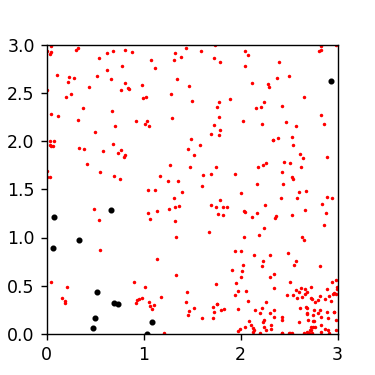

<IPython.core.display.Javascript object>


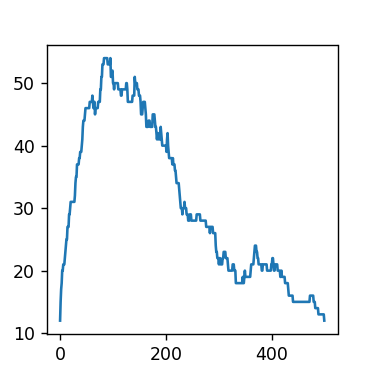

In [4]:
c = Const()
curve = model(c, show_dotses=True);
plt.figure(figsize=(3,3))
plt.plot(curve)